<a href="https://colab.research.google.com/github/NuelOzeh/Predicting-Smoking-Status-with-Artificial-Neural-Networks/blob/main/smokers_status.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from scipy import stats
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import L1L2
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.models import load_model

In [ ]:
!pip install --upgrade kaggle

In [ ]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c playground-series-s3e24

  0% 0.00/6.81M [00:00<?, ?B/s]
100% 6.81M/6.81M [00:00<00:00, 81.7MB/s]


In [ ]:
# from google.colab import files
# import json

# # Upload kaggle.json
# uploaded = files.upload()

# # Load Kaggle API key
# with open('kaggle.json') as f:
#     kaggle_api_key = json.load(f)

# # Set Kaggle API key
# import os
# os.environ['KAGGLE_USERNAME'] = kaggle_api_key["emmanuelozeh"]
# os.environ['KAGGLE_KEY'] = kaggle_api_key['6842174918c626ee063b446c79c27fea']

# # Download dataset
# !kaggle competitions download -c playground-series-s3e24

In [ ]:
!unzip "/content/playground-series-s3e24.zip" -d "/content/dataset"

Archive:  /content/playground-series-s3e24.zip
  inflating: /content/dataset/sample_submission.csv  
  inflating: /content/dataset/test.csv  
  inflating: /content/dataset/train.csv  


In [ ]:
csv_path = '/content/dataset/train.csv'

df = pd.read_csv(csv_path)
df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [ ]:
csv_path1 = '/content/dataset/test.csv'

test_dataset = pd.read_csv(csv_path1)
test_dataset.head(5)

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


In [ ]:
df.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,...,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,...,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,...,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,...,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


In [ ]:
df.isnull().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [ ]:
df.dtypes

id                       int64
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic                 int64
relaxation               int64
fasting blood sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
Urine protein            int64
serum creatinine       float64
AST                      int64
ALT                      int64
Gtp                      int64
dental caries            int64
smoking                  int64
dtype: object

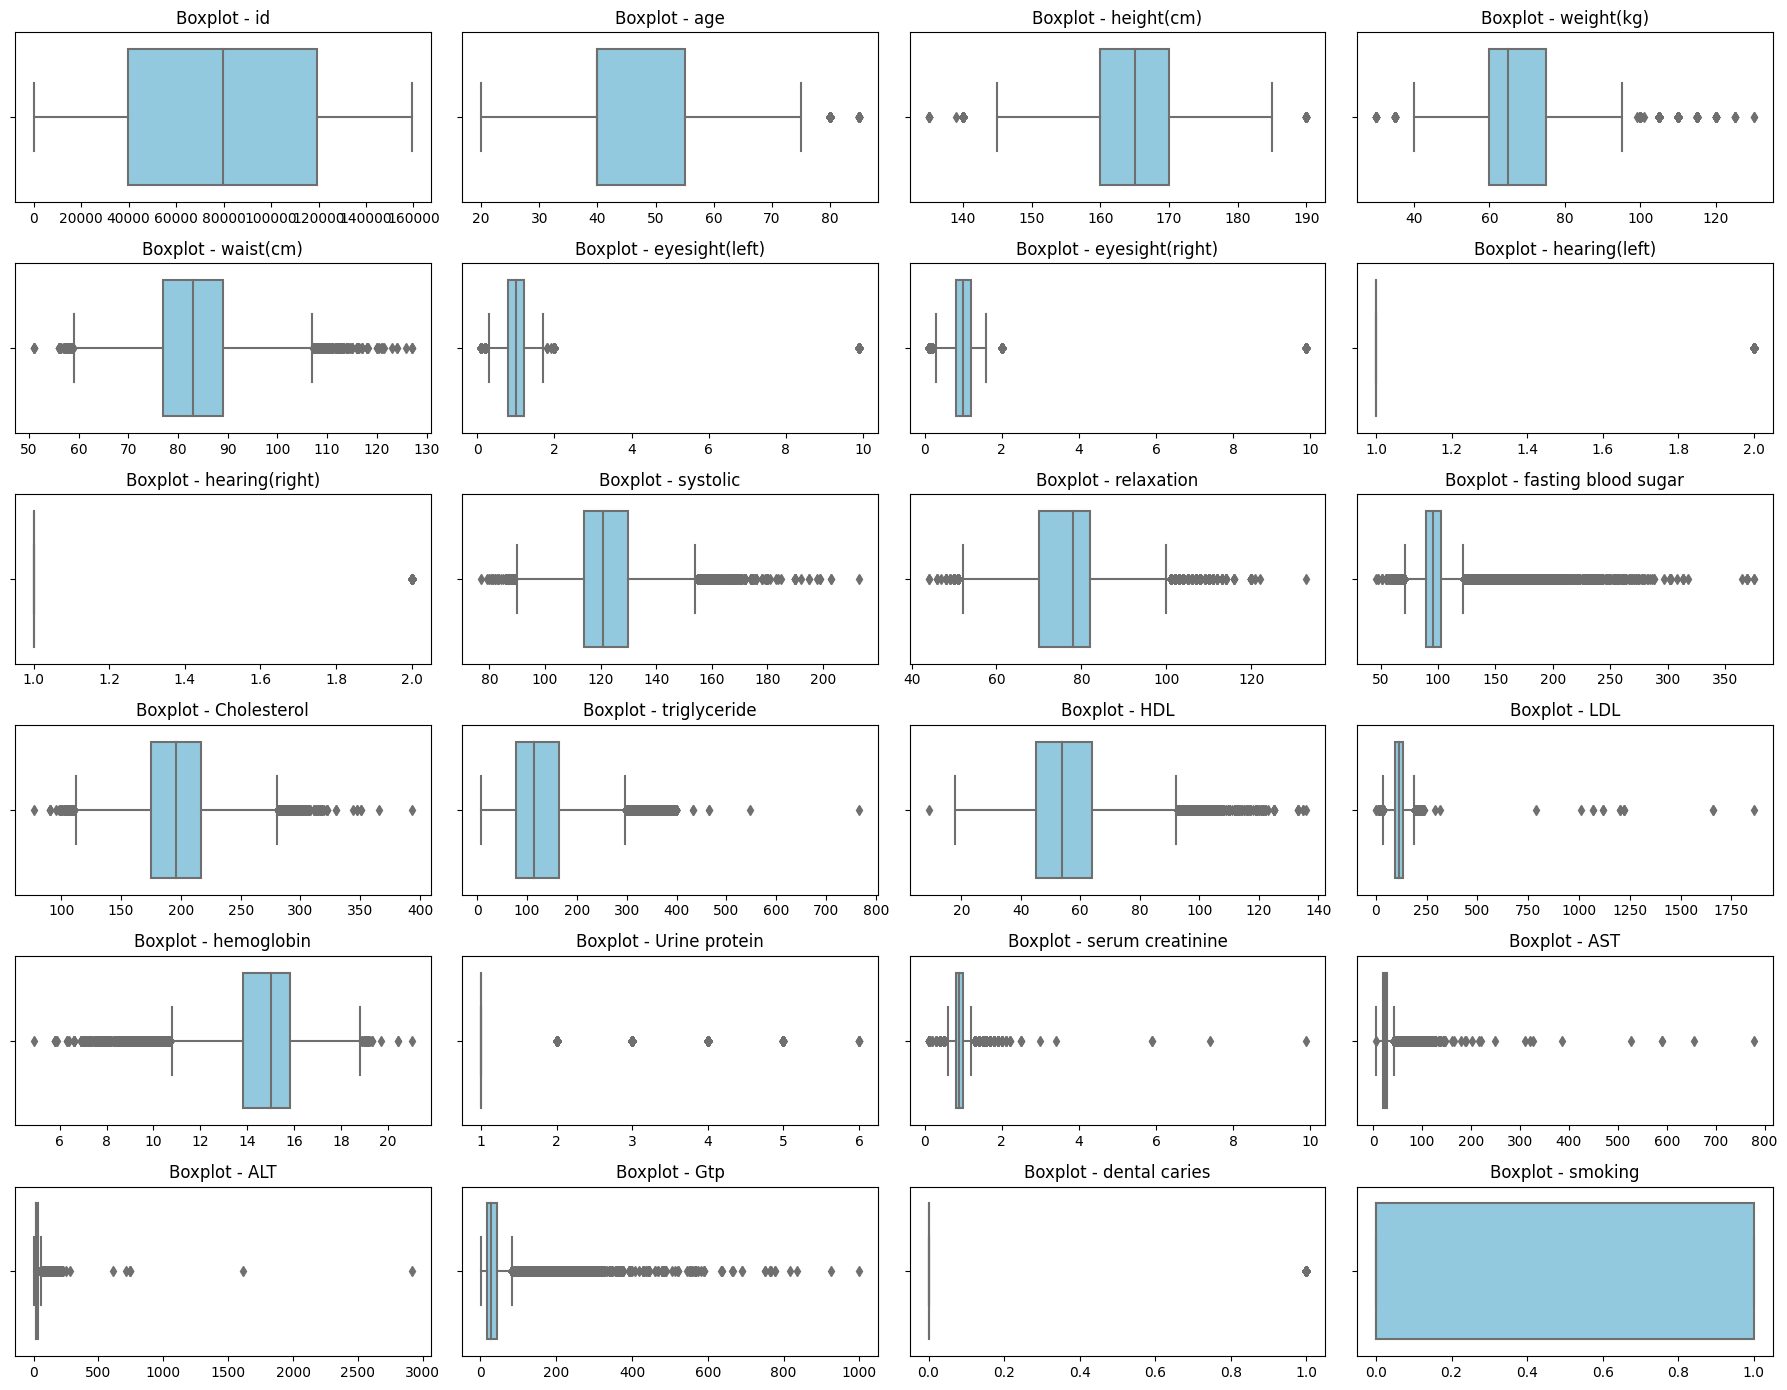

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data for 46 attributes
np.random.seed(24)
data = {f'Attribute_{i+1}': np.random.randn(100) for i in range(24)}
df = pd.DataFrame(df)

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(18, 14))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Loop through each attribute and create a boxplot
for i, (col, ax) in enumerate(zip(df.columns, axes)):
    sns.boxplot(x=df[col], ax=ax, color='skyblue')
    ax.set_title(f'Boxplot - {col}')
    ax.set_xlabel('')

# Adjust layout
plt.tight_layout()
plt.show()


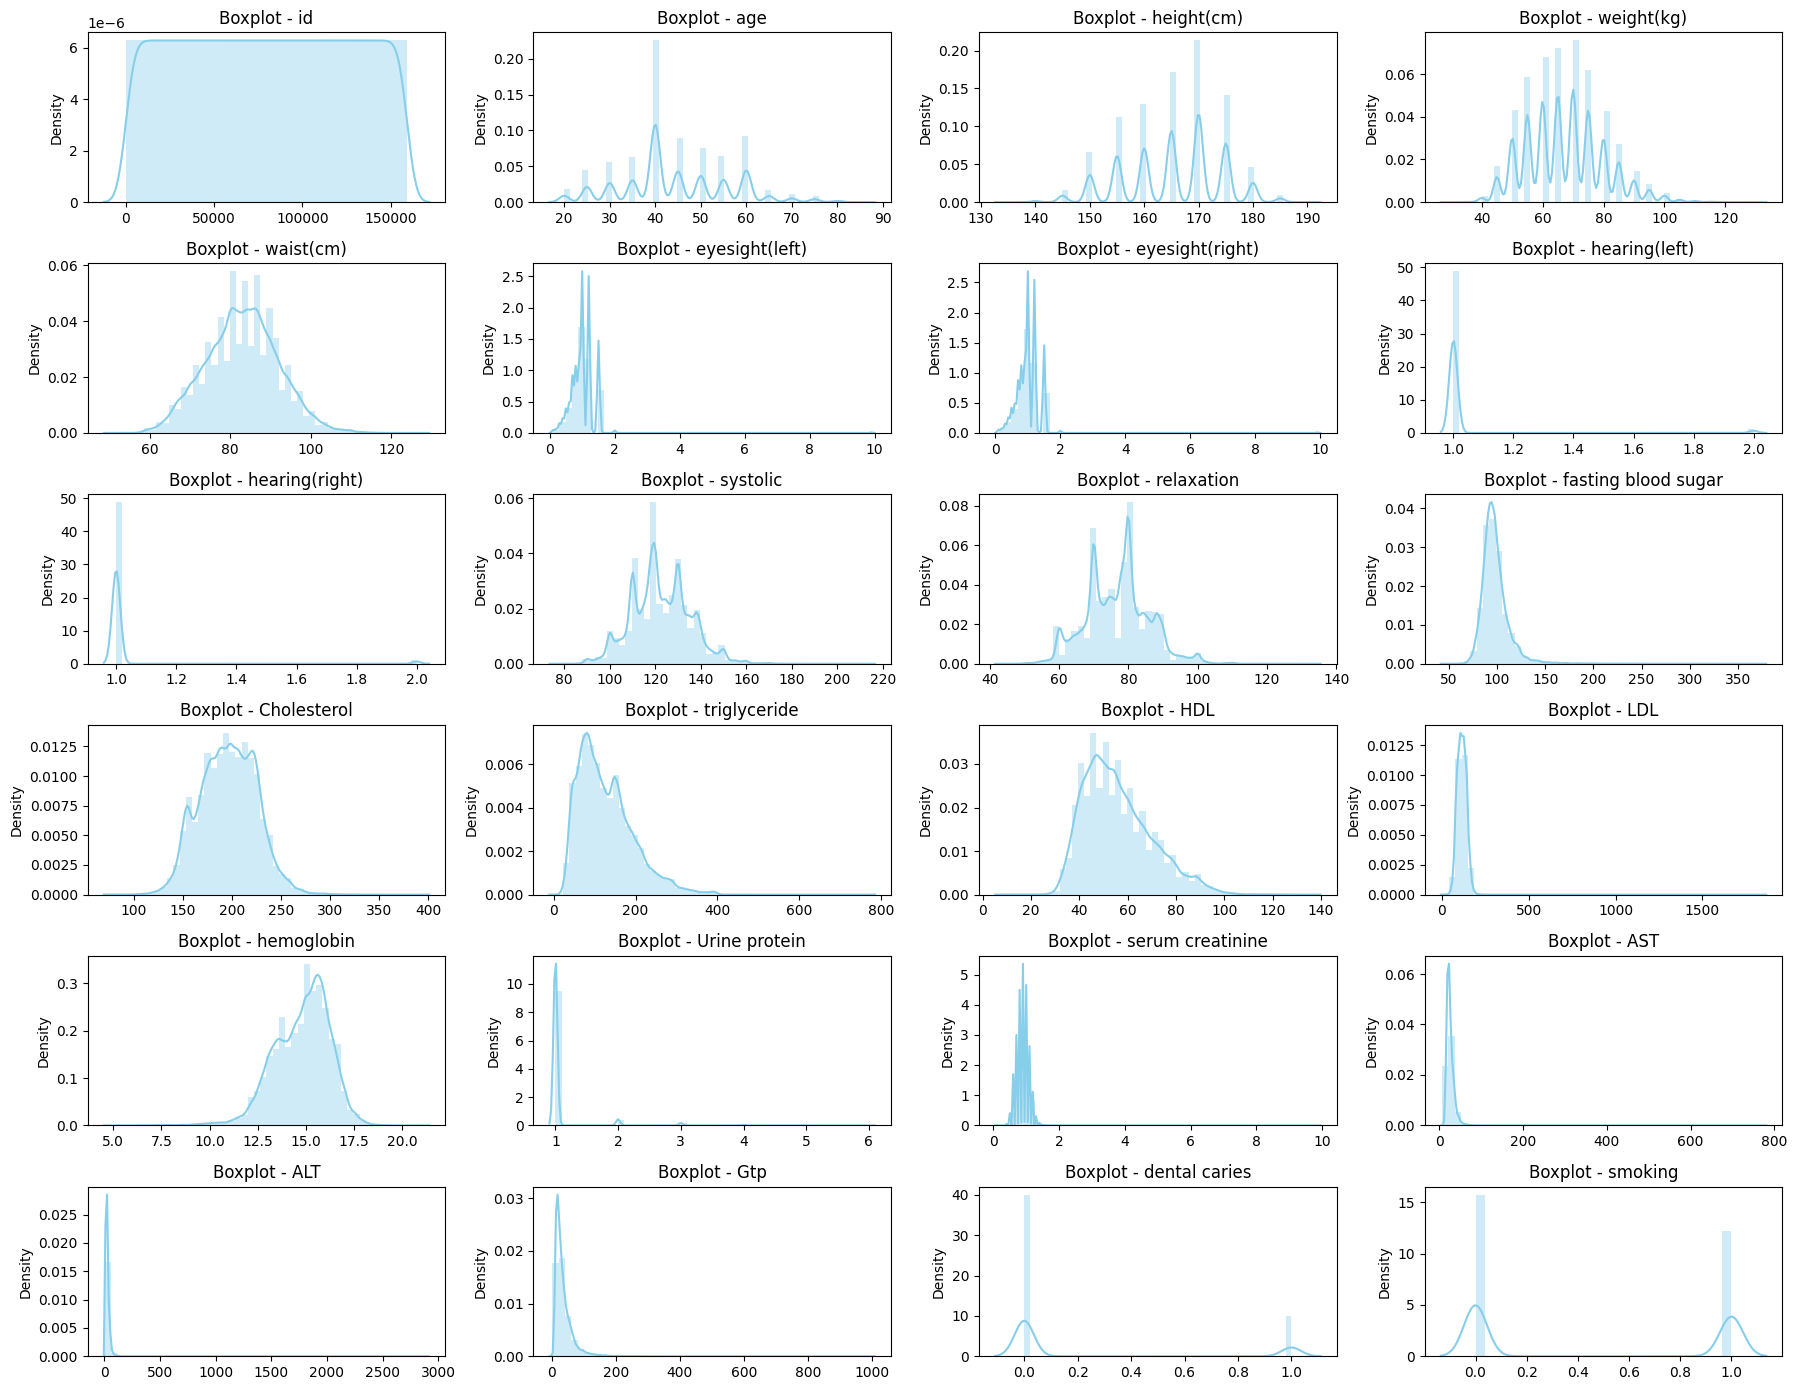

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data for 46 attributes
np.random.seed(24)
data = {f'Attribute_{i+1}': np.random.randn(100) for i in range(24)}
df = pd.DataFrame(df)

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(18, 14))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Loop through each attribute and create a boxplot
for i, (col, ax) in enumerate(zip(df.columns, axes)):
    sns.distplot(x=df[col], ax=ax, color='skyblue')
    ax.set_title(f'Boxplot - {col}')
    ax.set_xlabel('')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
#Checking for Label Imbalance
class_percentage = df['smoking'].value_counts(normalize=True) * 100

print(class_percentage)

0    56.2635
1    43.7365
Name: smoking, dtype: float64


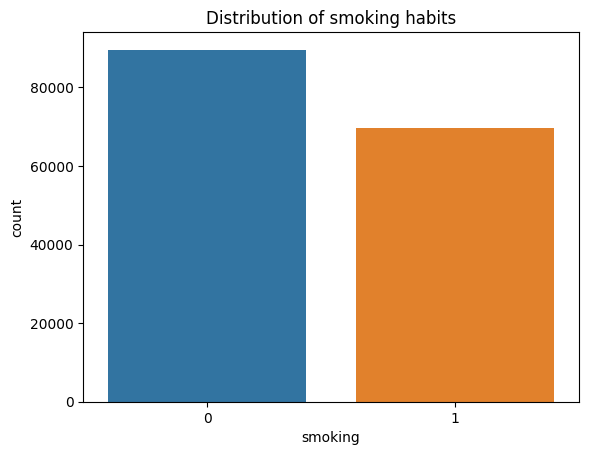

In [121]:
sns.countplot(x='smoking', data=df)
plt.title('Distribution of smoking habits')
plt.show()

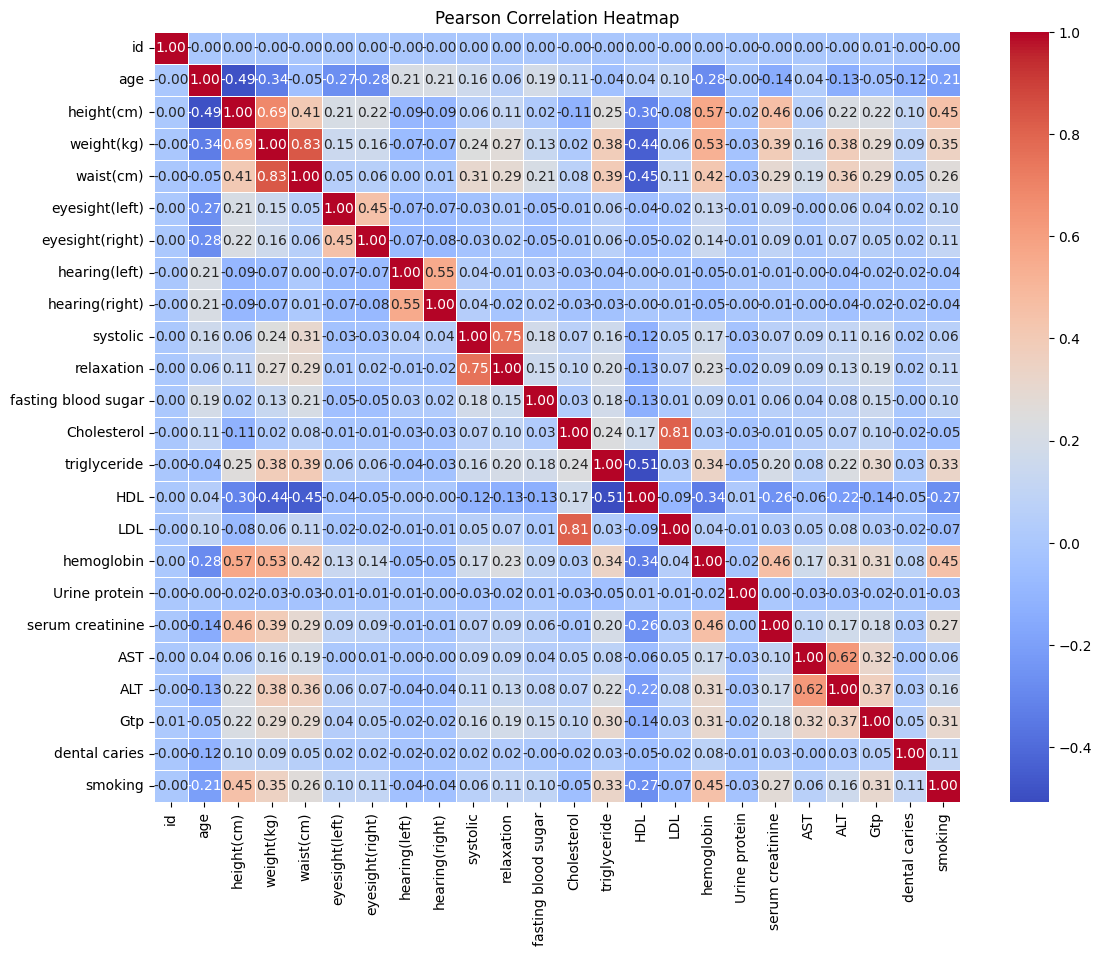

In [ ]:
#Explorung the correlated features
CORRELATION_MATRIX = df.corr()

plt.figure(figsize=(13, 10))
sns.heatmap(CORRELATION_MATRIX, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Heatmap")
plt.show()

In [79]:
q = df['eyesight(left)'].quantile(.9999)
eyesightL = df[df['eyesight(left)'] < q]

<Axes: xlabel='eyesight(left)', ylabel='Density'>

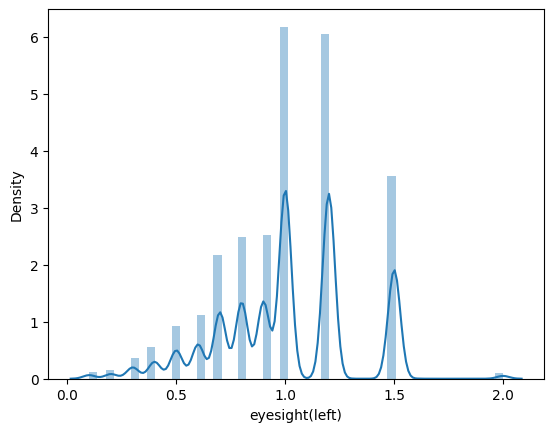

In [80]:
sns.distplot(eyesightL['eyesight(left)'])

In [86]:
q = df['eyesight(right)'].quantile(.99999)
eyesightR = eyesightL[eyesightL['eyesight(right)'] < q]

<Axes: xlabel='eyesight(right)', ylabel='Density'>

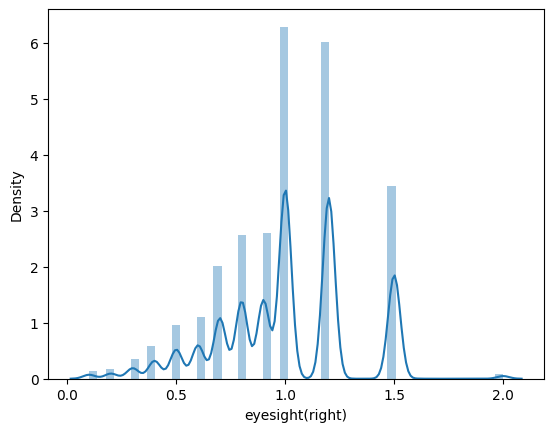

In [87]:
sns.distplot(eyesightR['eyesight(right)'])

In [88]:
q = df['systolic'].quantile(.999)
syst = eyesightR[eyesightR['systolic'] < q]

<Axes: xlabel='systolic', ylabel='Density'>

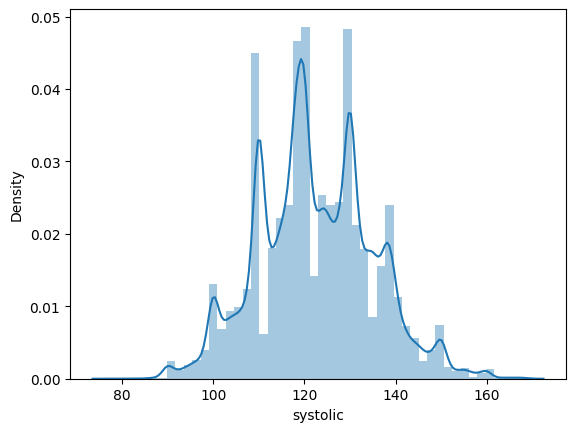

In [89]:
sns.distplot(syst['systolic'])

In [90]:
q = df['relaxation'].quantile(.999)
relax = syst[syst['relaxation'] < q]

<Axes: xlabel='relaxation', ylabel='Density'>

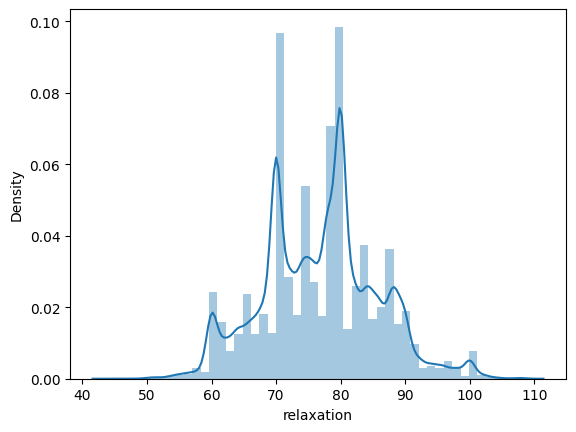

In [91]:
sns.distplot(relax['relaxation'])

In [93]:
q = df['fasting blood sugar'].quantile(.999)
fbs = relax[relax['fasting blood sugar'] < q]

<Axes: xlabel='fasting blood sugar', ylabel='Density'>

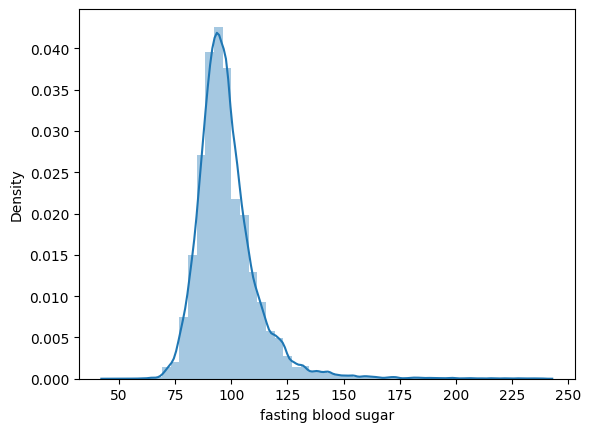

In [94]:
sns.distplot(fbs['fasting blood sugar'])

In [99]:
q = df['LDL'].quantile(.9999)
ldl = fbs[fbs['LDL'] < q]

<Axes: xlabel='LDL', ylabel='Density'>

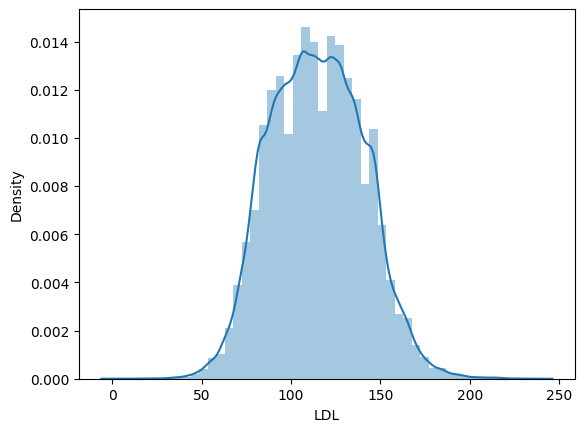

In [100]:
sns.distplot(ldl['LDL'])

In [45]:
q = df['Urine protein'].quantile(.999)
UP = ldl[ldl['Urine protein'] < q]

<Axes: xlabel='Urine protein', ylabel='Density'>

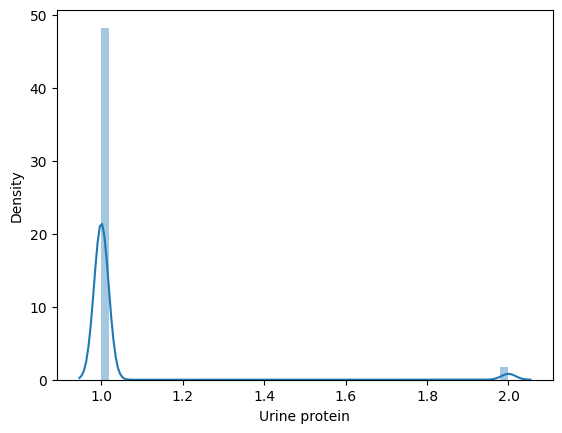

In [101]:
sns.distplot(UP['Urine protein'])

In [110]:
q = df['serum creatinine'].quantile(.9999)
SC = UP[UP['serum creatinine'] < q]

<Axes: xlabel='serum creatinine', ylabel='Density'>

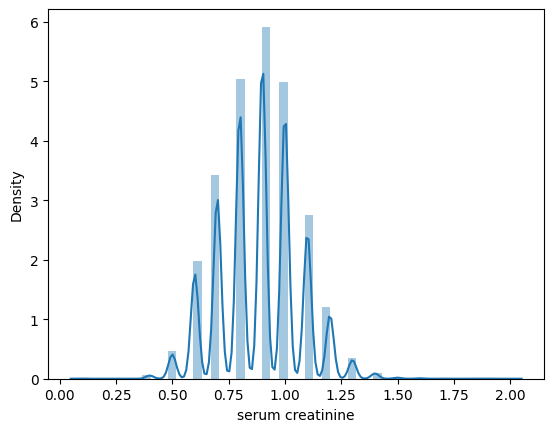

In [111]:
sns.distplot(SC['serum creatinine'])

In [106]:
q = df['AST'].quantile(.999)
ast = SC[SC['AST'] < q]

<Axes: xlabel='AST', ylabel='Density'>

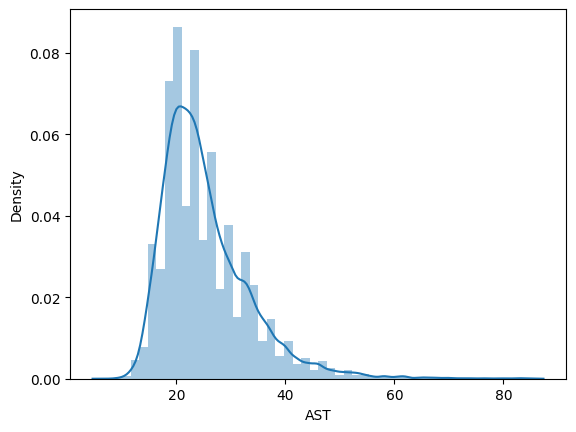

In [107]:
sns.distplot(ast['AST'])

In [104]:
q = df['ALT'].quantile(.999)
alt = ast[ast['ALT'] < q]

<Axes: xlabel='ALT', ylabel='Density'>

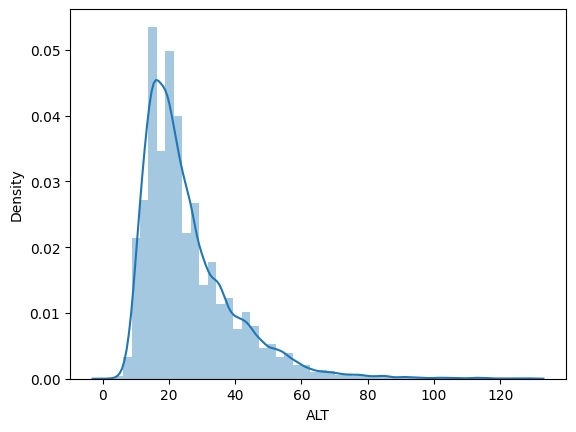

In [105]:
sns.distplot(alt['ALT'])

In [102]:
q = df['Gtp'].quantile(.999)
gtp = alt[alt['Gtp'] < q]

<Axes: xlabel='Gtp', ylabel='Density'>

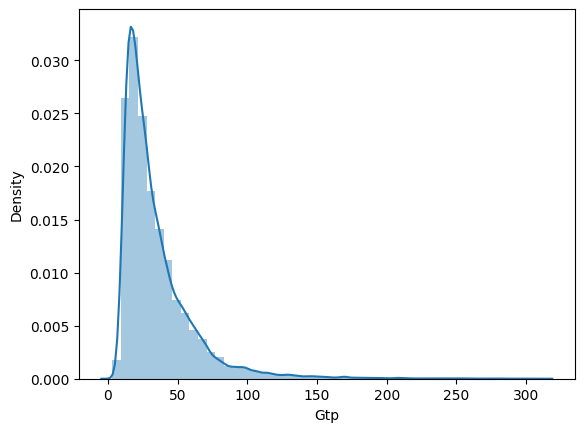

In [103]:
sns.distplot(gtp['Gtp'])

In [113]:
data_cleaned = gtp.reset_index(drop=True)

In [114]:
data_cleaned.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,117031.000000,117031.000000,117031.000000,117031.000000,117031.000000,117031.00000,117031.000000,117031.000000,117031.000000,117031.000000,...,117031.000000,117031.000000,117031.000000,117031.000000,117031.000000,117031.000000,117031.000000,117031.000000,117031.000000,117031.000000
mean,79630.665909,45.517700,164.453299,66.080064,82.592871,0.90552,0.902504,1.027847,1.027343,121.807786,...,56.302757,114.043817,14.690172,1.036238,0.876945,24.996719,25.382403,34.589613,0.192522,0.413660
std,45953.438597,11.921833,8.926998,12.412852,8.942447,0.24608,0.247663,0.164536,0.163082,12.197128,...,14.220582,25.137319,1.438140,0.186883,0.165896,7.289648,13.354599,26.756528,0.394282,0.492491
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.10000,0.100000,1.000000,1.000000,77.000000,...,18.000000,1.000000,4.900000,1.000000,0.100000,7.000000,1.000000,3.000000,0.000000,0.000000
25%,39822.000000,40.000000,160.000000,55.000000,76.200000,0.80000,0.800000,1.000000,1.000000,113.000000,...,46.000000,95.000000,13.700000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79647.000000,45.000000,165.000000,65.000000,83.000000,1.00000,1.000000,1.000000,1.000000,120.000000,...,54.000000,114.000000,14.900000,1.000000,0.900000,23.000000,22.000000,27.000000,0.000000,0.000000
75%,119345.000000,55.000000,170.000000,75.000000,88.900000,1.00000,1.000000,1.000000,1.000000,130.000000,...,65.000000,133.000000,15.700000,1.000000,1.000000,29.000000,31.000000,42.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,1.30000,1.400000,2.000000,2.000000,153.000000,...,136.000000,173.000000,21.000000,2.000000,1.200000,53.000000,129.000000,311.000000,1.000000,1.000000


In [ ]:
# LQ = 0.01
# UQ = 0.99


# def remove_outliers_quantile(X, lower_quantile = LQ, upper_quantile = UQ):
#     lower_bound = X.quantile(lower_quantile)
#     upper_bound = X.quantile(upper_quantile)

#     outliers = ((X < lower_bound) | (X > upper_bound)).any(axis=1)
#     cleaned_data = X[~outliers]

#     return cleaned_data

# # Dictionary to store cleaned datasets with variable names
# cleaned_datasets = {}

# # Loop through each column (parameter) in the DataFrame
# for col in df.columns:
#     # Check if the column contains numerical data
#     if pd.api.types.is_numeric_dtype(df[col]):
#         # Remove outliers using the Quantile method
#         cleaned_data = remove_outliers_quantile(df[[col]])

#         # Assign a variable name based on the original column name
#         variable_name = f"{col}_cleaned"

#         # Store the cleaned data in the dictionary
#         cleaned_datasets[variable_name] = cleaned_data

# # Access the cleaned datasets using their variable names
# for variable_name, cleaned_data in cleaned_datasets.items():
#     print(f"Variable Name: {variable_name}")
#     cleaned_data.head()

In [ ]:

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Generate random data for 24 attributes
# np.random.seed(24)
# data = {f'Attribute_{i+1}': np.random.randn(100) for i in range(24)}
# cleaned_data = pd.DataFrame(data)

# # Set up the matplotlib figure
# fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(18, 14))

# # Flatten the axes array to make it easier to iterate
# axes = axes.flatten()

# # Loop through each attribute and create a boxplot
# for i, (col, ax) in enumerate(zip(cleaned_data.columns, axes)):
#     sns.boxplot(x=cleaned_data[col], ax=ax, color='skyblue')
#     ax.set_title(f'Boxplot - {col}')
#     ax.set_xlabel('')

# # Adjust layout
# plt.tight_layout()
# plt.show()

In [115]:
#specifying my dependent and independent variables
X = data_cleaned.drop(['id', 'smoking'], axis=1)

y = data_cleaned["smoking"]

In [124]:
#fixing label imbalance

smote = SMOTE(random_state=2023)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [126]:
y_resampled.value_counts()

1    68620
0    68620
Name: smoking, dtype: int64

In [127]:
#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=2023)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [131]:
#Normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [150]:
BATCH_SIZE = 100
PATIENCE = 2
LR = 0.001
EPOCHS = 20
output_size = 2
# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
#model.add(BatchNormalization())


# Hidden layers
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
#model.add(BatchNormalization())


# Output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])

#patience/earlystopping......
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

#callbacks
def lr_scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
learning_rate_scheduler = LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(X_train,
          y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_split=0.1,
          callbacks=[early_stopping, learning_rate_scheduler],
          verbose = 2)



Epoch 1/20
791/791 - 4s - loss: 0.4977 - accuracy: 0.7602 - val_loss: 0.4576 - val_accuracy: 0.7822 - lr: 0.0010 - 4s/epoch - 4ms/step
Epoch 2/20
791/791 - 3s - loss: 0.4622 - accuracy: 0.7802 - val_loss: 0.4516 - val_accuracy: 0.7871 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 3/20
791/791 - 2s - loss: 0.4581 - accuracy: 0.7833 - val_loss: 0.4464 - val_accuracy: 0.7893 - lr: 9.0484e-04 - 2s/epoch - 2ms/step
Epoch 4/20
791/791 - 2s - loss: 0.4533 - accuracy: 0.7850 - val_loss: 0.4474 - val_accuracy: 0.7895 - lr: 8.1873e-04 - 2s/epoch - 2ms/step
Epoch 5/20
791/791 - 2s - loss: 0.4506 - accuracy: 0.7871 - val_loss: 0.4429 - val_accuracy: 0.7909 - lr: 7.4082e-04 - 2s/epoch - 2ms/step
Epoch 6/20
791/791 - 2s - loss: 0.4489 - accuracy: 0.7883 - val_loss: 0.4481 - val_accuracy: 0.7873 - lr: 6.7032e-04 - 2s/epoch - 2ms/step
Epoch 7/20
791/791 - 2s - loss: 0.4471 - accuracy: 0.7895 - val_loss: 0.4403 - val_accuracy: 0.7929 - lr: 6.0653e-04 - 2s/epoch - 2ms/step
Epoch 8/20
791/791 - 2s - loss: 0.4

In [145]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                1472      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5697 (22.25 KB)
Trainable params: 5697 (22.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [151]:
# Evaluate the model on the test set
print('________________________________________________________________________________________')
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print('________________________________________________________________________________________')

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print('________________________________________________________________________________________')

print("Classification Report:\n", classification_report(y_test, y_pred))

________________________________________________________________________________________
858/858 [==============================] - 1s 2ms/step
Accuracy: 0.7776522879626931
________________________________________________________________________________________
Confusion Matrix:
 [[ 8287  5437]
 [  666 13058]]
________________________________________________________________________________________
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.60      0.73     13724
           1       0.71      0.95      0.81     13724

    accuracy                           0.78     27448
   macro avg       0.82      0.78      0.77     27448
weighted avg       0.82      0.78      0.77     27448



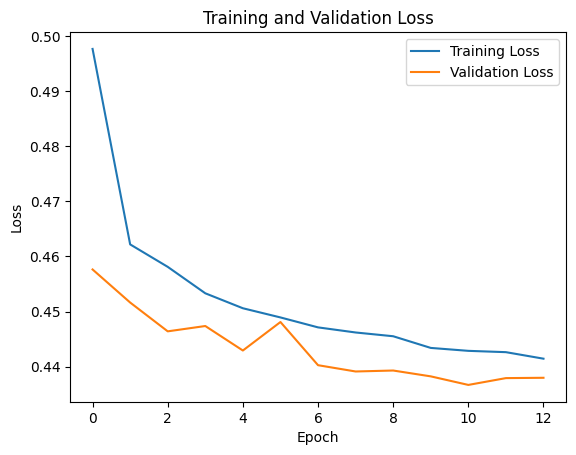

In [152]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [147]:
#scores = model.evaluate(test_dataset)

858/858 [==============================] - 4s 5ms/step


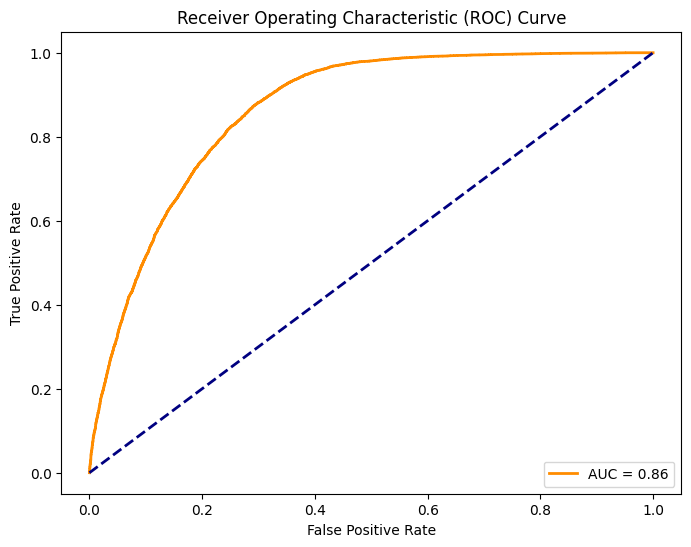

AUC Score: 0.86


In [148]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Calculate AUC score
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print(f'AUC Score: {roc_auc:.2f}')

In [ ]:
model.save('smokers_habit')

In [ ]:
my_model = load_model('smokers_habit')

In [ ]:
y_pred_prob = my_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Predictions:", y_pred)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
